# DO NOT CLICK "RUN ALL": This notebook contains dangerous cells that may reset progress made

In [18]:
import os
import cv2
import numpy as np
import json
import shutil
from matplotlib import pyplot as plt
from PIL import Image


In [19]:
# Data exploration and visualization functions for the casting dataset

cwd = os.getcwd()
dataset_path = "C:/Datasets/Casting"

class_names = ["burr", "polished", "pol_burr", "crack", "pit", "scratch", "strain", "unpolished"]
class_colors = {"burr": (0, 255, 0), "crack": (0, 0, 255), "pit": (255, 0, 0), "scratch": (255, 255, 0), "strain": (0, 255, 255), "unpolished": (255, 0, 255)}

class_count = {"burr": 0, "no_defect":0, "crack":0, "pit":0, "unpolished":0}

image_count = {"zero":0, "um":0,"dois":0,"tres":0, "mais_que_tres":0 }

dataset_size = {"count":0}

new_class_names = ["burr", "crack", "pit", "unpolished", "no_defect"]
new_class_colors = {"burr": (255, 0, 0), "crack": (0, 0, 255), "pit": (0, 255, 0), "unpolished": (0, 255, 255), "no_defect": (255, 0, 255)}

image_blacklist = ["cast_def_0_3292","cast_def_0_3380","cast_def_0_937","cast_def_0_9276","cast_def_0_5214","cast_def_0_5205","cast_def_0_7994","cast_def_0_9079"]

# Count the number of classes present in a YOLO format annotation file
def count_classes(boxes):
	if len(boxes) == 0:
		return 0
	
	classes = []
	for box in boxes:
		class_id = box[0]
		if class_id not in classes:
			classes.append(class_id)
	return len(classes)

# return a list of classes present
def included_classes(boxes):
	classes = []
	for box in boxes:
		class_id = box[0]
		if class_id not in classes:
			classes.append(class_id)
	return sorted(classes)


# Function to read YOLOv5 format bounding boxes from a text file
def read_yolo_boxes(file_path):
	with open(file_path, 'r') as file:
		lines = file.readlines()
		boxes = []
		for line in lines:
			box_data = line.strip().split()
			
			if len(box_data) == 0:
				continue
			
			class_id = int(box_data[0])
			x_center = float(box_data[1])
			y_center = float(box_data[2])
			width = float(box_data[3])
			height = float(box_data[4])


			### CLASS FILTER ###

			# if class_id == 1:
			# 	continue

			# if class_id == 2:
			# 	class_id = 0

			####################

			boxes.append((class_id, x_center, y_center, width, height))

	return boxes

# Function to draw bounding boxes on an image
def draw_boxes(image, boxes, class_names):
    for box in boxes:
        class_id, x_center, y_center, width, height = box

        # Check if the width or height is less than 0.01
        if width < 0.01 or height < 0.01:
            continue
            
        
        left = int((x_center - width/2) * image.shape[1])
        top = int((y_center - height/2) * image.shape[0])
        right = int((x_center + width/2) * image.shape[1])
        bottom = int((y_center + height/2) * image.shape[0])
        class_name = class_names[class_id]
        class_color = class_colors[class_name]
        cv2.rectangle(image, (left, top), (right, bottom), class_color, 2)
        cv2.putText(image, class_name, (left, top - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, class_color, 5)
    return image

def annotate_image(image_path, annotation_path):
	image = cv2.imread(image_path)
	image_name = os.path.basename(image_path)

	if any(bl in image_name for bl in image_blacklist):
		return

	boxes = read_yolo_boxes(annotation_path)
	annotated_image = draw_boxes(image, boxes, class_names)
      
	num_classes = count_classes(boxes)
	incl_classes = included_classes(boxes)
	num_anots = len(boxes)
	
	# Save the annotated image in a folder with the same name as the class
	# class_folder = os.path.join(cwd, "output", str(num_classes))
	# if not os.path.exists(class_folder):
	# 	os.makedirs(class_folder)
	# image_name = os.path.basename(image_path)
	# output_path = os.path.join(class_folder, image_name)
	# cv2.imwrite(output_path, annotated_image)
	# print("Annotated image saved to", output_path)

	def save_image(image, folder, name):
		if not os.path.exists(folder):
			os.makedirs(folder)
		elif os.path.exists(os.path.join(folder, name)):
			return
		
		output_path = os.path.join(folder, name)
		cv2.imwrite(output_path, image)
		print("Annotated image saved to", output_path)

	if 5 in incl_classes and 6 in incl_classes:
		class_folder = os.path.join(cwd, "output", "5 e 6 (scratch e strain)")
		save_image(annotated_image, class_folder, image_name)
	elif 5 in incl_classes:
		class_folder = os.path.join(cwd, "output", "somente 5 (scratch)")
		save_image(annotated_image, class_folder, image_name)
	elif 6 in incl_classes:
		class_folder = os.path.join(cwd, "output", "somente 6 (strain)")
		save_image(annotated_image, class_folder, image_name)
	else:
		if num_anots == 0:
			image_count["zero"] += 1
			class_folder = os.path.join(cwd, "output", "0 defeitos")
			save_image(annotated_image, class_folder, image_name)
		
		elif num_anots == 1:
			image_count["um"] += 1
			class_folder = os.path.join(cwd, "output", "1 defeito")
			save_image(annotated_image, class_folder, image_name)
		
		elif num_anots == 2:
			image_count["dois"] += 1
			class_folder = os.path.join(cwd, "output", "2 defeitos")
			save_image(annotated_image, class_folder, image_name)
		
		elif num_anots == 3:
			image_count["tres"] += 1
			class_folder = os.path.join(cwd, "output", "3 defeitos")
			save_image(annotated_image, class_folder, image_name)
		
		else:
			image_count["mais_que_tres"] += 1
			class_folder = os.path.join(cwd, "output", "mais que 3 defeitos")
			save_image(annotated_image, class_folder, image_name)


	dataset_size["count"] += 1


		


	



In [38]:
# Annotate all images in the dataset for visualization purposes, also separate them into different sorted folders based on number and type of defects

images_train_folder = os.path.join(dataset_path, "train", "images")
annotations_train_folder = os.path.join(dataset_path, "train", "labels")

train_images = os.listdir(images_train_folder)
train_annotations = os.listdir(annotations_train_folder)

images_test_folder = os.path.join(dataset_path, "test", "images")
annotations_test_folder = os.path.join(dataset_path, "test", "labels")

test_images = os.listdir(images_test_folder)
test_annotations = os.listdir(annotations_test_folder)

images_valid_folder = os.path.join(dataset_path, "valid", "images")
annotations_valid_folder = os.path.join(dataset_path, "valid", "labels")

valid_images = os.listdir(images_valid_folder)
valid_annotations = os.listdir(annotations_valid_folder)

def annotate_section(images, annotations, images_folder, annotations_folder):
	for image_name in images:
		image_path = os.path.join(images_folder, image_name)
		annotation_name = image_name.replace(".jpg", ".txt")
		annotation_path = os.path.join(annotations_folder, annotation_name)
		annotate_image(image_path, annotation_path)

In [34]:
annotate_section(train_images, train_annotations, images_train_folder, annotations_train_folder)
annotate_section(test_images, test_annotations, images_test_folder, annotations_test_folder)
annotate_section(valid_images, valid_annotations, images_valid_folder, annotations_valid_folder)

{'zero': 893, 'um': 645, 'dois': 626, 'tres': 109, 'mais_que_tres': 22}


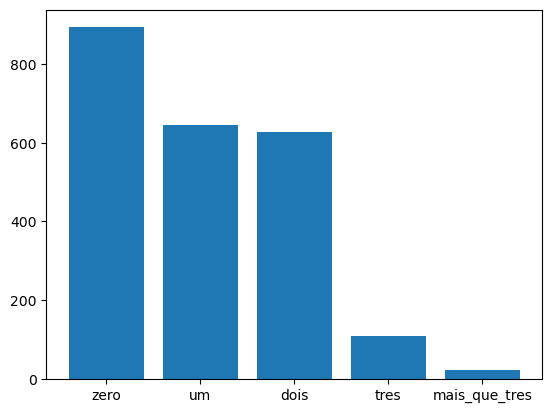

In [19]:
# Plot dataset distribution based on number of defects per image
print(image_count)

total_dataset = sum(image_count.values())

partial_dataset = image_count["zero"] + image_count["um"] + image_count["dois"] + image_count["tres"]

plt.bar(image_count.keys(), image_count.values())
plt.show()



Inteiro: 4244
Somente 5 (scratch): 1852
Somente 6 (strain): 63
5 e 6 (scratch e strain): 34


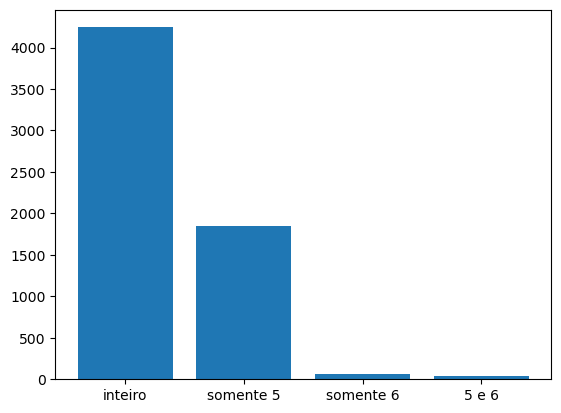

In [35]:
# Plot dataset distribution excluding images that include scratch, strain
somente5_folder = os.path.join(cwd, "output", "somente 5 (scratch)")
somente6_folder = os.path.join(cwd, "output", "somente 6 (strain)")
cincoeseis_folder = os.path.join(cwd, "output", "5 e 6 (scratch e strain)")

inteiro = partial_dataset + len(os.listdir(somente5_folder)) + len(os.listdir(somente6_folder)) + len(os.listdir(cincoeseis_folder))

print("Inteiro:", dataset_size["count"])
print("Somente 5 (scratch):", len(os.listdir(somente5_folder)))
print("Somente 6 (strain):", len(os.listdir(somente6_folder)))
print("5 e 6 (scratch e strain):", len(os.listdir(cincoeseis_folder)))

plt.bar (["inteiro", "somente 5", "somente 6", "5 e 6"], [dataset_size["count"], len(os.listdir(somente5_folder)), len(os.listdir(somente6_folder)), len(os.listdir(cincoeseis_folder))])
plt.show()

In [8]:
# Creates the dataset used for the model training, testing and validation

import json
import shutil
import os

cwd = os.getcwd()
dataset_path = "C:/Datasets/Casting"
image_blacklist = ["cast_def_0_3292","cast_def_0_3380","cast_def_0_937","cast_def_0_9276","cast_def_0_5214","cast_def_0_5205","cast_def_0_7994","cast_def_0_9079"]

def make_dataset(dataset_path,target):
	output_folder = os.path.join(cwd, "dataset", target)
	image_output_folder = os.path.join(output_folder, "images")
	label_output_folder = os.path.join(output_folder, "labels")
	json_output_path = os.path.join(output_folder, "dataset.json")

	if not os.path.exists(output_folder):
		os.makedirs(output_folder)
		os.makedirs(image_output_folder)
		os.makedirs(label_output_folder)

	target_folder = os.path.join(dataset_path, target)

	images_folder = os.path.join(target_folder, "images")
	labels_folder = os.path.join(target_folder, "labels")

	images = os.listdir(images_folder)
	labels = os.listdir(labels_folder)

	dataset_info = []  # List to store dataset information

	for label in labels:

		image_name = label.replace(".txt", ".jpg")
		if any(bl in image_name for bl in image_blacklist):
			continue

		
		boxes = read_yolo_boxes(os.path.join(labels_folder, label))

		incl_classes = included_classes(boxes)

		if 5 in incl_classes or 6 in incl_classes or len(boxes) > 3:
			continue
		else:
			image_output_path = os.path.join(output_folder, "images", image_name)
			annotation_output_path = os.path.join(output_folder, "labels", label)

			# Copy the image and annotation to the output folder
			image_input_path = os.path.join(images_folder, image_name)
			annotation_input_path = os.path.join(labels_folder, label)

			# Create a new label file with the correct class ids using boxes data
			with open(annotation_output_path, 'w') as file:
				for box in boxes:
					class_id, x_center, y_center, width, height = box

					if class_id == 1:
						continue
					elif class_id == 2:
						class_id = 0
					elif class_id == 3:
						class_id = 1
					elif class_id == 4:
						class_id = 2
					elif class_id == 5:
						continue
					elif class_id == 6:
						continue
					elif class_id == 7:
						class_id = 3

					file.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

			# if annotation file is empty, save the image to json file
			if os.path.getsize(annotation_output_path) == 0:
				#get relative image path
				image_rel_path = os.path.join("dataset", target, "images", image_name)
				dataset_info.append({
					'image_path': image_rel_path,
				})
					
			if not os.path.exists(image_output_path):
				shutil.copyfile(image_input_path, image_output_path)
			# if not os.path.exists(annotation_output_path):
			# 	shutil.copyfile(annotation_input_path, annotation_output_path)

	 # Write dataset_info to JSON file
	with open(json_output_path, 'w') as json_file:
		json.dump(dataset_info, json_file, indent=4)  

	

	print("Done. copied", len(os.listdir(image_output_folder)), "images to", output_folder)
	print("Dataset information written to", json_output_path)			


	

In [9]:
make_dataset(dataset_path, "train")
make_dataset(dataset_path, "test")
make_dataset(dataset_path, "valid")

Done. copied 1958 images to c:\Users\luizh\Desktop\estagio\notebooks\casting\dataset\train
Dataset information written to c:\Users\luizh\Desktop\estagio\notebooks\casting\dataset\train\dataset.json
Done. copied 110 images to c:\Users\luizh\Desktop\estagio\notebooks\casting\dataset\test
Dataset information written to c:\Users\luizh\Desktop\estagio\notebooks\casting\dataset\test\dataset.json
Done. copied 205 images to c:\Users\luizh\Desktop\estagio\notebooks\casting\dataset\valid
Dataset information written to c:\Users\luizh\Desktop\estagio\notebooks\casting\dataset\valid\dataset.json


In [5]:
# Creates a JSON file with paths to images that have no annotations for manual annotation
# The JSON file is used by our annotation tool to override the label file for images that originally had not annotations

import os
import json

target = "valid"

output_folder = os.path.join(cwd, "dataset", target)
labels_folder = os.path.join(output_folder, "labels")
json_output_path = os.path.join(output_folder, "dataset.json")

labels = os.listdir(labels_folder)

dataset_info = []  # List to store dataset information	

count = 0

# For each label, check if label file is empty, if so, add image to json file for manual annotation
for label in labels:
	annotation_output_path = os.path.join(output_folder, "labels", label)
	image_name = label.replace(".txt", ".jpg")

	bboxes = read_yolo_boxes(annotation_output_path)

	if len(bboxes) == 0:
		count += 1
		image_rel_path = os.path.join("dataset", target, "images", image_name)
		dataset_info.append({
			'image_path': image_rel_path,
		})

# delete current dataset.json file
if os.path.exists(json_output_path):
	os.remove(json_output_path)

# Write dataset_info to JSON file
with open(json_output_path, 'w') as json_file:
	json.dump(dataset_info, json_file, indent=4)

print("Done. Added", count, "images to", json_output_path)



Done. Added 0 images to c:\Users\luizh\Desktop\estagio\notebooks\casting\dataset\valid\dataset.json


In [4]:
# Check for invalid or missing annotations e.g. human error in labeling when respecifying the class ids manually
# Used to check if you need to run the previous cell again to fix the annotations

import os

cwd = os.getcwd()

target = "valid"

output_folder = os.path.join(cwd, "dataset", target)
labels_folder = os.path.join(output_folder, "labels")

labels = os.listdir(labels_folder)

invalid_annotations = []

for label in labels:
	try:
		bboxes = read_yolo_boxes(os.path.join(labels_folder, label))
	except:
		print("Error reading label", label)
	# if len(bboxes) == 0:
	# 	invalid_annotations.append(label)
	# 	continue

	for bbox in bboxes:
		class_id, x_center, y_center, width, height = bbox
		if width == 0 or height == 0:
			invalid_annotations.append(label)
			break
		elif class_id == 4 and len(bboxes) > 1:
			invalid_annotations.append(label)
			break

print("Invalid annotations:", invalid_annotations)
print(len(invalid_annotations), "invalid annotations found.")


Invalid annotations: []
0 invalid annotations found.


In [5]:
# Compute mean pixel values for each channel, used for normalization in the model

import os
import cv2
import numpy as np

cwd = os.getcwd()

output_folder = os.path.join(cwd, "dataset", "train")

images_folder = os.path.join(output_folder, "images")

images = os.listdir(images_folder)

mean_values = np.zeros(3)

for image_name in images:
	image_path = os.path.join(images_folder, image_name)
	image = cv2.imread(image_path)
	mean_values += np.mean(image, axis=(0,1))

mean_values /= len(images)

print("Mean pixel values:", mean_values)



Mean pixel values: [144.17631833 144.17631833 144.17631833]


In [ ]:
# DANGER ZONE: Clean the output folder

import os

output_folder = os.path.join(os.getcwd(), "output")

# Remove the output folder and its contents recursively
shutil.rmtree(output_folder)

# Recreate the output folder
os.makedirs(output_folder)

print("Output folder cleaned.")


In [8]:
# Create a new folder for the dataset that joins test+valid folders


import shutil
from distutils.dir_util import copy_tree

cwd = os.getcwd()
dataset_path = os.path.join(cwd, "dataset")

output_folder = os.path.join(cwd, "dataset", "test+valid")

if not os.path.exists(output_folder):
	os.makedirs(output_folder)

# Copy the images and labels from test and valid folders to the new folder
images_test_folder = os.path.join(dataset_path, "test", "images")
labels_test_folder = os.path.join(dataset_path, "test", "labels")

images_valid_folder = os.path.join(dataset_path, "valid", "images")
labels_valid_folder = os.path.join(dataset_path, "valid", "labels")

copy_tree(images_test_folder, os.path.join(output_folder, "images"))
copy_tree(labels_test_folder, os.path.join(output_folder, "labels"))

copy_tree(images_valid_folder, os.path.join(output_folder, "images"))
copy_tree(labels_valid_folder, os.path.join(output_folder, "labels"))


output_count = len(os.listdir(os.path.join(output_folder, "images")))
print(f"Copied {output_count} images and labels from test and valid folders to {output_folder}")




Copied 315 images and labels from test and valid folders to c:\Users\luizh\Desktop\estagio\notebooks\casting\dataset\test+valid


In [11]:
# Creates a new test folder named "test30" with a subset of test folder with 30 carefully selected images
# the images were selected using the annotation tool because it already had logic to select balanced classes

# the images were then manually fine-tuned for a better balance

# do not run this cell again, it will overwrite the test30 folder

# Helper function to save an image to a folder
def save_image2(image, folder, filename):
    if not os.path.exists(folder):
        os.makedirs(folder)
    elif os.path.exists(os.path.join(folder, filename)):
        return
    
    output_path = os.path.join(folder, filename)
    cv2.imwrite(output_path, image)
    print("Annotated image saved to", output_path)

# Function to draw bounding boxes on an image
def draw_boxes2(image, boxes, class_names):
    for box in boxes:
        class_id, x_center, y_center, width, height = box

        # Check if the width or height is less than 0.01
        if width < 0.01 or height < 0.01:
            print("Tried to draw a box with width or height less than 0.01")
            print("There is probably an error in the annotation file")
            continue

        left = int((x_center - width/2) * image.shape[1])
        top = int((y_center - height/2) * image.shape[0])
        right = int((x_center + width/2) * image.shape[1])
        bottom = int((y_center + height/2) * image.shape[0])
        class_name = new_class_names[class_id]
        class_color = new_class_colors[class_name]
        cv2.rectangle(image, (left, top), (right, bottom), class_color, 2)
        cv2.putText(image, class_name, (left, top - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, class_color, 5)
    return image

# Helper function to read YOLOv5 format bounding boxes, and draw them on an image, then save it
def annotate_image2(image_path, dest_folder, annotation_path):
    try:
        image = cv2.imread(image_path)
    except:
        print("Error reading image", image_path)
        return
    
    image_filename = os.path.basename(image_path)

    boxes = read_yolo_boxes(annotation_path)
    annotated_image = draw_boxes2(image, boxes, class_names)
    save_image2(annotated_image, dest_folder, image_filename)


cwd = os.getcwd()

# read the .txt file with the list of selected images
selected_images = []
with open("30_imagens_escolhidas.txt", 'r') as file:
    lines = file.readlines()
    for line in lines:
        selected_images.append(line.strip())

# Create a new folder for the dataset
output_folder = os.path.join(cwd, "dataset", "test30")
src_folder = os.path.join(cwd, "dataset", "test")

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Copy the images and labels from test folder to the new folder
images_test_folder = os.path.join(output_folder, "images")
images_gt_folder = os.path.join(output_folder, "images_gt")
labels_test_folder = os.path.join(output_folder, "labels")

if not os.path.exists(images_test_folder):
    os.makedirs(images_test_folder)
if not os.path.exists(images_gt_folder):
    os.makedirs(images_gt_folder)
if not os.path.exists(labels_test_folder):
    os.makedirs(labels_test_folder)

for image_name in selected_images:

    src_path = os.path.join(src_folder, "images", image_name)

    if not os.path.exists(src_path):
        print("Image not found:", src_path)
        continue

    image_path = os.path.join(images_test_folder, image_name)
    gt_path = os.path.join(images_gt_folder, image_name)
    label_path = os.path.join(labels_test_folder, image_name.replace(".jpg", ".txt"))

    original_label_path = os.path.join(src_folder, "labels", image_name.replace(".jpg", ".txt"))

    annotate_image2(src_path, images_gt_folder, original_label_path)

    shutil.copyfile(src_path, image_path)
    shutil.copyfile(original_label_path, label_path)

print(f"Copied {len(selected_images)} images and labels from test folder to {output_folder}")





Annotated image saved to c:\Users\luizh\Desktop\estagio\notebooks\casting\dataset\test30\images_gt\cast_ok_0_5536_jpeg.rf.7e68844f3ba03544c3cafc7a35686833.jpg
Annotated image saved to c:\Users\luizh\Desktop\estagio\notebooks\casting\dataset\test30\images_gt\cast_ok_0_8113_jpeg.rf.ab8767e81686506103fd7fcf2d5c48a2.jpg
Annotated image saved to c:\Users\luizh\Desktop\estagio\notebooks\casting\dataset\test30\images_gt\cast_def_0_5331_jpeg.rf.39e2612f156de01ef45fe61be9f83927.jpg
Annotated image saved to c:\Users\luizh\Desktop\estagio\notebooks\casting\dataset\test30\images_gt\cast_def_0_5768_jpeg.rf.81e8aac5bdd2ad52a12a2c74a47e403c.jpg
Annotated image saved to c:\Users\luizh\Desktop\estagio\notebooks\casting\dataset\test30\images_gt\cast_ok_0_7005_jpeg.rf.5ae93417546c45bf0fb27f4c2f9ee878.jpg
Annotated image saved to c:\Users\luizh\Desktop\estagio\notebooks\casting\dataset\test30\images_gt\cast_def_0_2010_jpeg.rf.be75792dfa1625cb574b9fc9d44b5ba0.jpg
Annotated image saved to c:\Users\luizh\Des

In [17]:
# counts number of classes and number of boxes per image in the test30 dataset

# just displays the counts

cwd = os.getcwd()

test30_folder = os.path.join(cwd, "dataset", "test30")

images_folder = os.path.join(test30_folder, "images")
labels_folder = os.path.join(test30_folder, "labels")

test30_images = os.listdir(images_folder)
test30_labels = os.listdir(labels_folder)

inv_class_mapping = {0: "burr", 1:"crack", 2:"pit", 3:"unpolished", 4:"no_defect"}
class_count = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
box_count = {"0":0, "1":0, "2":0, "3":0, "mais_que_tres":0 }

for label in test30_labels:
    boxes = read_yolo_boxes(os.path.join(labels_folder, label))
    class_ids = included_classes(boxes)
    num_classes = len(class_ids)

    if num_classes > 3:
        num_classes = "mais_que_tres"

    box_count[str(num_classes)] += 1

    ### ISSO TA ERRADO NAO CONSIDERA QUANDO TEM MAIS DE UMA CAIXA DE UMA MESMA CLASSE
    for class_id in class_ids:
        class_count[class_id] += 1



print("Contagem de classes")
for key, value in class_count.items():
    print(f"{inv_class_mapping[key]}: {value}")

print("Caixas por imagem")
for key, value in box_count.items():
    print(f"{key}: {value}")


Contagem de classes
burr: 8
crack: 11
pit: 9
unpolished: 9
no_defect: 8
Caixas por imagem
0: 0
1: 16
2: 13
3: 1
mais_que_tres: 0


In [6]:
# creates a manifest json file for ALL the subsets of the dataset

cwd = os.getcwd()

dataset_path = os.path.join(cwd, "dataset")

subsets = ["train", "test", "valid", "test+valid", "test30"]

manifest = {}

for subset in subsets:
    subset_folder = os.path.join(dataset_path, subset)
    images_folder = os.path.join(subset_folder, "images")
    labels_folder = os.path.join(subset_folder, "labels")

    images = os.listdir(images_folder)
    labels = os.listdir(labels_folder)

    subset_info = []

    for label in labels:
        image_name = label.replace(".txt", ".jpg")
        image_rel_path = os.path.join("dataset", subset, "images", image_name)

        boxes = read_yolo_boxes(os.path.join(labels_folder, label))

        annotation_data = []

        for box in boxes:
            class_id, x_center, y_center, width, height = box
            annotation_data.append({
                'class_id': class_id,
                'x_center': x_center,
                'y_center': y_center,
                'width': width,
                'height': height
            })
        
        subset_info.append({
            'image_path': image_rel_path,
            'annotation_data': annotation_data
        })

    # shuffle the order of the images
    np.random.shuffle(subset_info)

    manifest[subset] = subset_info



manifest_output_path = os.path.join(os.getcwd(), "manifest.json")

# Write dataset_info to JSON file
with open(manifest_output_path, 'w') as json_file:
    json.dump(manifest, json_file, indent=4)